## Fourier methods

The Fourier transform (FT) for a well-behaved functions $f$ is defined as:

$$f(k) = \int e^{-ikx} f(x) ~dx$$

The inverse FT is then 

$$f(x) = \frac{1}{2\pi} \int e^{ikx} f(k) ~dk$$



## Discrete Fourier transforms (DFTs)


If the function is periodic in real space, $f(x+L) = f(x)$, then the Fourier space is discrete with spacing $\frac{2\pi}{L}$. Moreover, if the real space is periodic as well as discrete with the spacing $h$, then the Fourier space is discrete as well as bounded.  

$$f(x) = \sum e^{ikx} f(k) ~dk~~~~~~      \text{where } k = \Bigg[ -\frac{\pi}{h}, \frac{\pi}{h}\Bigg];~~ \text{with interval} \frac{2\pi}{L} $$


This is very much in line with crystallography with $ [ -\frac{\pi}{h}, \frac{\pi}{h} ]$ being the first Brillouin zone. So we see that there is a concept of the maximum wavenumber $ k_{max}=\frac{\pi}{h} $, we will get back to this later in the notes. Usually in computations we need to find FT of discrete function rather than of a well defined analytic function. Since the real space is discrete and periodic, the Fourier space is also discrete and periodic or bounded. Also, the Fourier space is continuous if the real space is unbounded. If the function is defined at $N$ points in real space and one wants to calculate the function at $N$ points in Fourier space, then **DFT** is defined as 

$$f_k = \sum_{n=0}^{N-1} f_n ~ e^{-i\frac{2\pi~n~k}{N}}$$

while the inverse transform of this is

$$f_n = \frac1N \sum_{n=0}^{N-1} f_k ~ e^{~i\frac{2\pi~n~k}{N}}$$

To calculate each $f_n$ one needs $N$ computations and it has to be done $N$ times, i.e, the algorithm is simply $\mathcal{O}(N^2)$. This can be implemented numerically as a matrix multiplication, $f_k = M\cdot f_n$, where $M$ is a $N\times N$ matrix.


## Fast fourier tranforms (FFTs)

The discussion here is based on the Cooley-Tukey algorithm. FFTs improves on DFTs by exploiting their symmetries.

$$ \begin{align}
f_k &= \sum_{n=0}^{N-1} f_n  e^{-i~\frac{2\pi~k~n}{N}} \\
&= \sum_{n=0}^{N/2-1} f_{2n} e^{-i~\frac{2\pi~k~2n}{N}} &+ \sum_{n=0}^{N/2-1} f_{2n + 1} e^{-i~\frac{2\pi~k~(n+1)}{N}}\\
&= \sum_{n=0}^{N/2 - 1} f_{2n} e^{-i~\frac{2\pi k~n}{N/2}} &+ e^{-i\frac{2\pi k}{N}} \sum_{n=0}^{N/2 - 1} f_{2n + 1} e^{-i~\frac{2\pi~k~n~}{N/2}}\\
&=\vdots &\vdots
\end{align}$$

We can use the symmetry property, from the definition, $f_{N+k} = f_k$. Notice that, because of the tree structure, there are $\ln_2 N$ stages of the calculation. By applying the method of splitting the computation in two halves recursively, the complexity of the problem becomes  $\mathcal{O}(N \ln N)$  while the naive algorithm is $\mathcal{O}(N^2)$. This is available in standard python packages like numpy and scipy.

We will now use PyGL to explore its usage to solve physics problems.

In [1]:
import pygl
import numpy as np
import matplotlib.pyplot as plt

dim, Nx, Ny = 2, 128, 128
grid = {"dim":dim, "Nx":Nx, "Ny":Ny}

# now construct the spectral solver
ss = pygl.dms.FourierSpectral(grid)

#### We first demonstrate the translation of blob using momentum operator

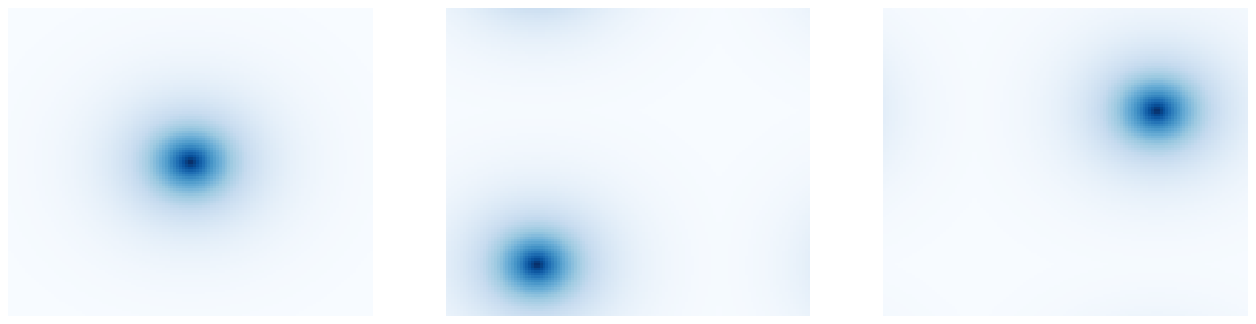

In [2]:
#  The momentum operator, e^{-ikr}, generates translation!

f = plt.figure(figsize=(20, 5), dpi=80);  
L, N = 128, 128       
x, y = np.meshgrid(np.linspace(0, L, N), np.linspace(0, L, N))
rr = np.sqrt( ((x-L/2)*(x-L/2)+(y-L/2)*(y-L/2))*.5 )
sig = np.fft.fft2(np.exp(-0.1*rr))


def plotFirst(x, y, sig, n_):
    sp =  f.add_subplot(1, 3, n_ )
    plt.pcolormesh(x, y, sig, cmap=plt.cm.Blues)
    plt.axis('off');     

xx = ([0, -L/4, -L/2,])
yy = ([0, -L/3,  L/2])
for i in range(3):
    kdotr = ss.kx*xx[i] + ss.ky*yy[i]
    sig = sig*np.exp(-1j*kdotr)
    plotFirst(x, y, np.real(np.fft.ifftn(sig)), i+1)

### Sampling: Aliasing error

We saw that because of the smallest length scale, $h$, in the real space there is a corresponding largest wave-vector, $k_{max}$ in the Fourier space. The error is because of this $k_{max}$ and a signal which has $k>k_{max}$ can not be distinguished on this grid. In the given example, below, we see that if the real space has 10 points that one can not distinguish between $sin(2\pi x/L)$ and $sin(34 \pi x/L)$. In general, $sin(k_1 x)$ and $sin(k_2 x)$ can not be distinguished if $k_1 -k_2$ is a multiple of $\frac{2\pi}{h}$. This is a manifestation of the gem called the sampling theorem which is defined, as on wikipedia:

If a function x(t) contains no frequencies higher than B hertz, it is completely determined by giving its ordinates at a series of points spaced 1/(2B) seconds apart.


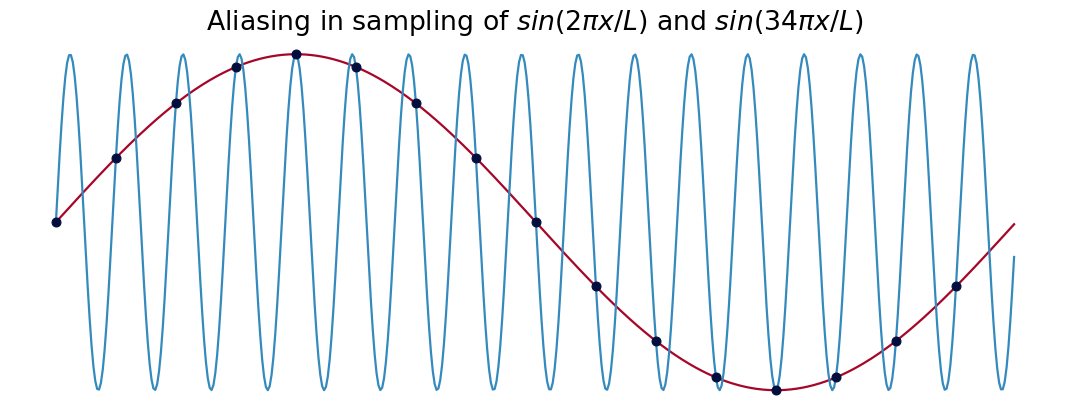

In [3]:
L, N = 1, 16
x = np.arange(0, L, L/512)
xx = np.arange(0, L, L/N)

def ff(k, x):
    return np.sin(k*x)

f = plt.figure(figsize=(17, 6), dpi=80);  

plt.plot(x, ff(x, 2*np.pi), color="#A60628", linewidth=2);
plt.plot(x, ff(x, 34*np.pi), color="#348ABD", linewidth=2);
plt.plot(xx, ff(xx, 2*np.pi), 'o', color="#020e3e", markersize=8)
plt.xlabel('x', fontsize=15); plt.ylabel('y(x)', fontsize=15);
plt.title('Aliasing in sampling of $sin(2\pi x/L)$ and $sin(34 \pi x/L)$', fontsize=24);
plt.axis('off');

To avoid this error, we truncate higher mode in PyGL using `ss.dealias'

### Differentiation
 
We now show the usage of PyGL to compute differentiation matrices. We first compute the second derivative of $\cos x$.

In [4]:
import pygl
import numpy as np
import matplotlib.pyplot as plt

dim, Nx, Ny = 1, 32, 32
grid = {"dim":dim, "Nx":Nx, "Ny":Ny}

ss = pygl.dms.FourierSpectral(grid)

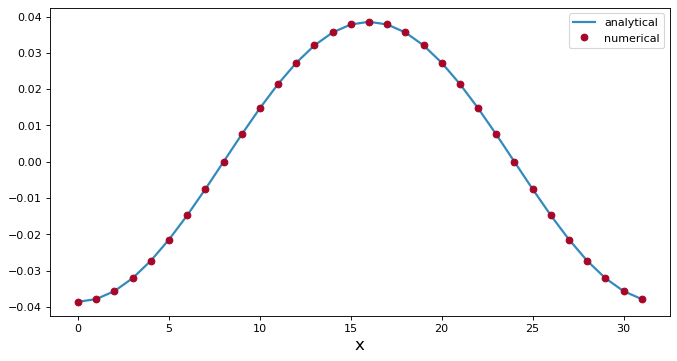

In [5]:
def f1(kk, x):
    return np.cos(kk*x)


f = plt.figure(figsize=(10, 5), dpi=80);  

L, N = Nx, Nx;   x=np.arange(0, N);  fac=2*np.pi/L
k = ss.kx

fk = np.fft.fft(f1(fac, x))         
f1_kk = -k*k*fk               
f1_xx = np.real(np.fft.ifft(f1_kk))

 
plt.plot(x, -f1(fac, x)*fac*fac, color="#348ABD", label = 'analytical', linewidth=2)          
plt.plot(x, f1_xx, 'o', color="#A60628", label = 'numerical', markersize=6)     
plt.legend(loc = 'best'); plt.xlabel('x', fontsize=15);